### Importing the Libaries

In [1]:
#Main Libaries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
import warnings
warnings.filterwarnings('ignore')
sns.set(rc = {'figure.figsize':[7,7]},font_scale = 1)

#Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sklearn
from sklearn.datasets import load_boston

#Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## Reading the Data

In [2]:
df = pd.read_excel('Data_Train.xlsx')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [4]:
df.shape

(10683, 11)

In [5]:
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [6]:
#converting the date from object type to date type
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format = '%d/%m/%Y')

#appending month, weekday & day to the dateset
df['Month'] = df['Date_of_Journey'].dt.month
df['Weekday'] = df['Date_of_Journey'].dt.day_name()
df['Day'] = df['Date_of_Journey'].dt.day

#converting the numrical value of the month to string(season)
def check_season(month):
    if month == 1 or month == 2:
        return 'Winter'
    if month == 3 or month == 4:
        return 'Spring'
    if month == 5 or month == 6:
        return 'Summer'
    if month == 7 or month == 8:
        return 'Monsoon'
    if month == 9 or month == 10:
        return 'Autumn'
    if month == 11 or month == 12:
        return 'Pre_winter'
df['Season'] = df['Month'].apply(lambda x: check_season(x))

#getting the weekend
df['Weekend'] = df['Weekday'].apply(lambda y: 1 if y == 'Sunday' else 0)

#convering the duration from object type to int type in seconds only
def convert_dur(duration):
    try:
        hr_to_sec = int(duration.split()[0].replace('h',''))*60*60
    except:
        hr_to_sec = 0
    try:
        min_to_sec = int(duration.split()[1].replace('m',''))*60
    except:
        min_to_sec = 0
    return hr_to_sec + min_to_sec
df['Duration'] = df['Duration'].apply(lambda x: convert_dur(x))

In [7]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Month,Weekday,Day,Season,Weekend
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,10200,non-stop,No info,3897,3,Sunday,24,Spring,1
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,26700,2 stops,No info,7662,5,Wednesday,1,Summer,0
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,68400,2 stops,No info,13882,6,Sunday,9,Summer,1
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,19500,1 stop,No info,6218,5,Sunday,12,Summer,1
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,17100,1 stop,No info,13302,3,Friday,1,Spring,0


In [8]:
#required functions for visualization
def countplot(data, x, palette, title, fsize = None, y = None, hue = None):
    plt.figure(figsize = fsize)
    sns.countplot(data = data, x = x, y = y, palette = palette, hue = hue)
    plt.xlabel(x.title(), color = 'red', size = 15)
    plt.ylabel('Count', color = 'red', size = 15)
    plt.xticks(rotation = 25)
    plt.title(title.title(), color = 'red', size = 15)
    if hue != None:
        plt.legend(title=hue.title())
    plt.show()

def barplot(data, x, palette, title, fsize = None, y = None, hue = None, estimator = mean):
    plt.figure(figsize = fsize)
    sns.barplot(data = data, x = x, y = y, palette = palette, hue = hue, estimator=estimator)
    plt.xlabel(x.title(), color = 'red', size = 15)
    plt.ylabel(y.title(), color = 'red', size = 15)
    plt.xticks(rotation = 25)
    plt.title(title.title(), color = 'red', size = 15)
    if hue != None:
        plt.legend(title=hue.title())
    plt.show()

def scatterplot(data,x,y,title):
    sns.scatterplot(data = data, x = x, y = y)
    plt.xlabel(x.title(), color = 'red', size = 15)
    plt.ylabel(y.title(), color = 'red', size = 15)
    plt.title(title.title(),color='red',size=15)
    plt.show()

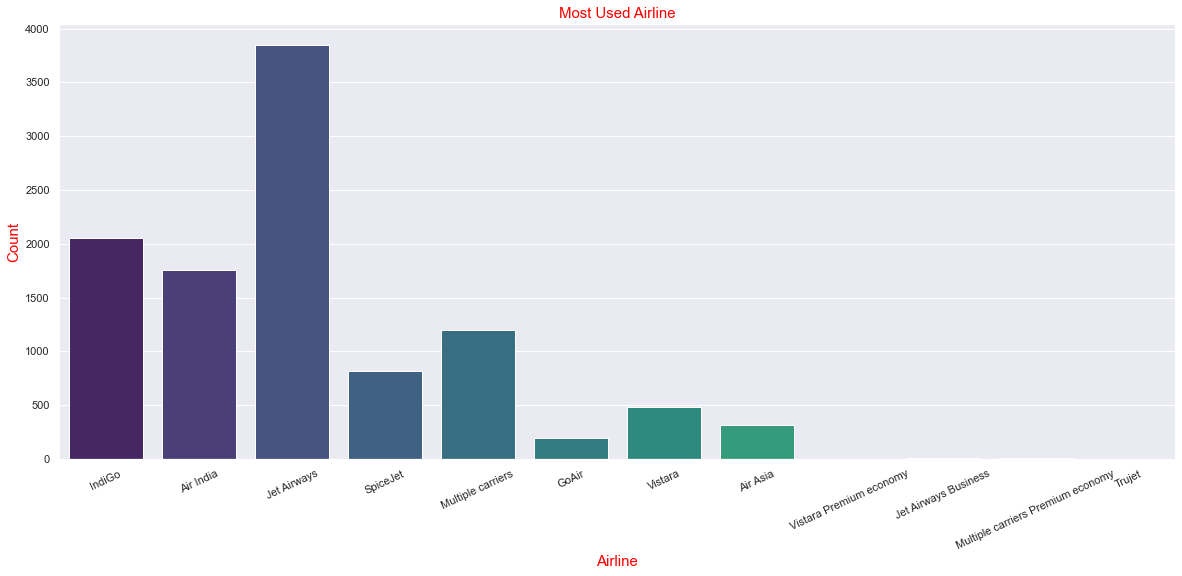

In [9]:
countplot(df, 'Airline', 'viridis', 'Most used Airline', (20,8))

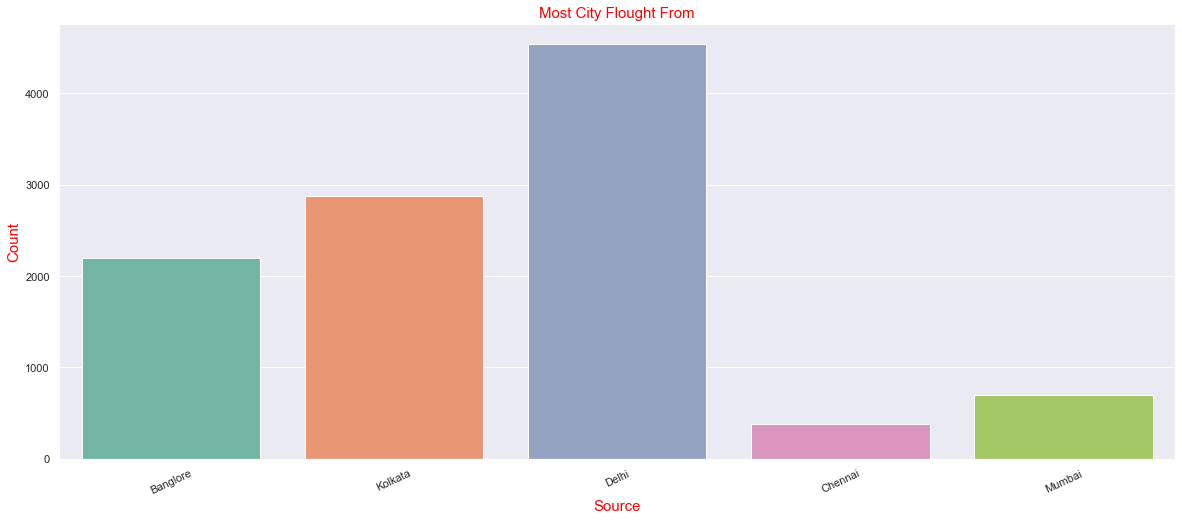

In [10]:
countplot(df, 'Source', 'Set2', 'Most city flought from', (20,8))

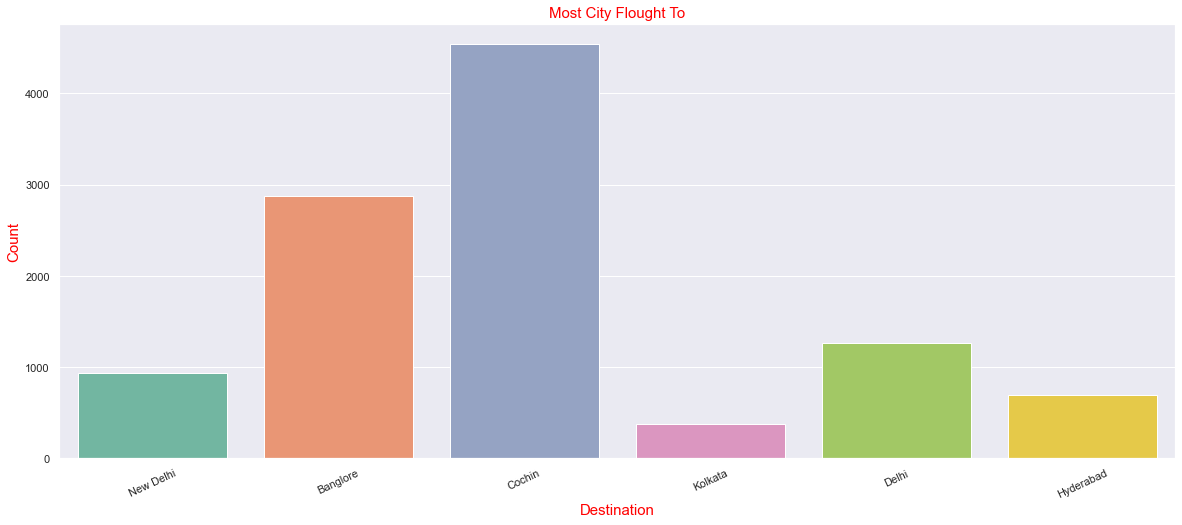

In [11]:
countplot(df, 'Destination', 'Set2', 'Most city flought to', (20,8))

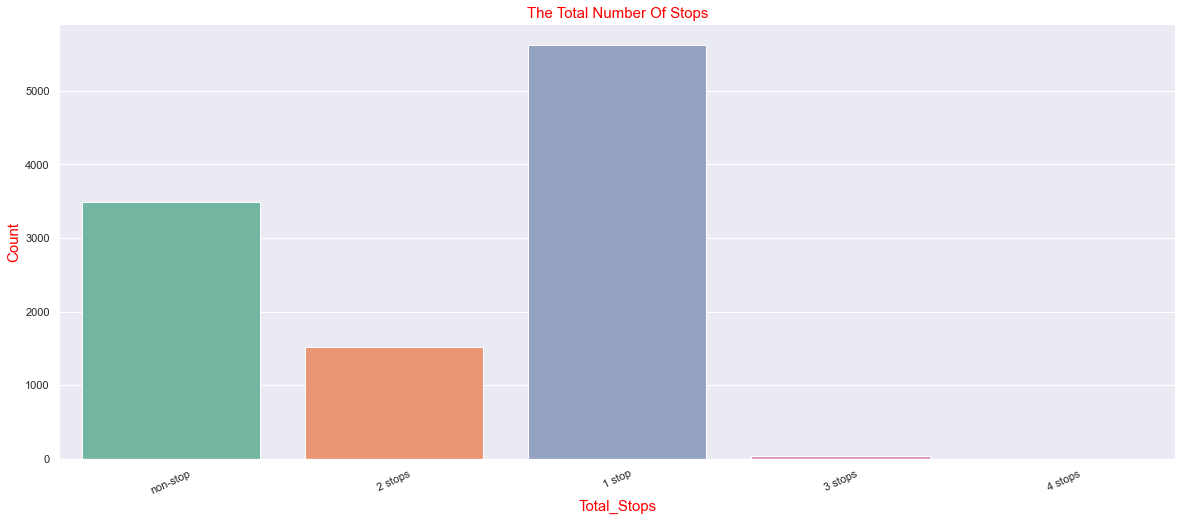

In [12]:
countplot(df, 'Total_Stops', 'Set2', 'the total number of stops', (20,8))

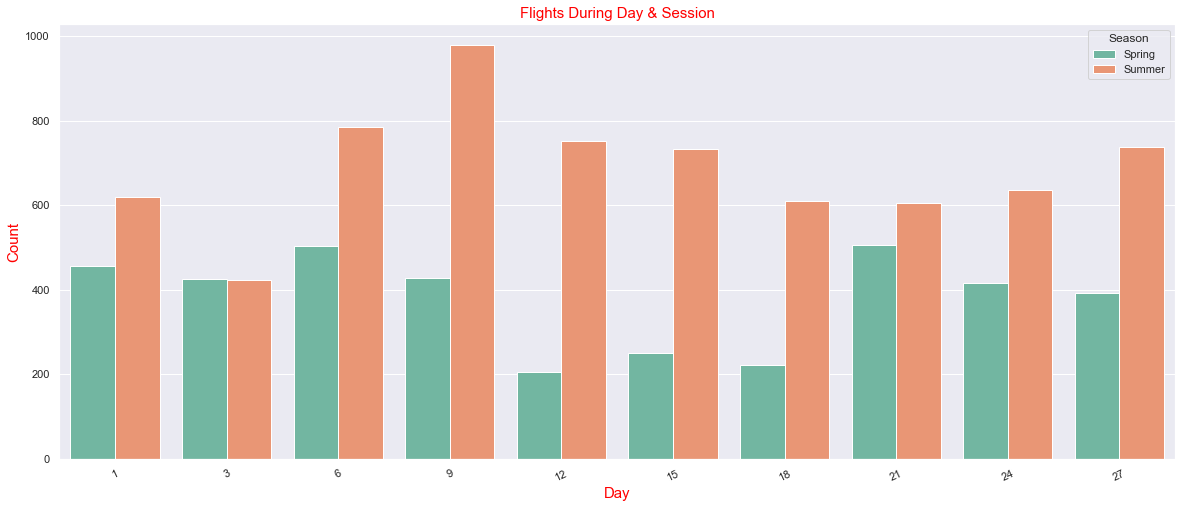

In [13]:
countplot(df, 'Day', 'Set2', 'Flights during day & session', (20,8), hue = 'Season')

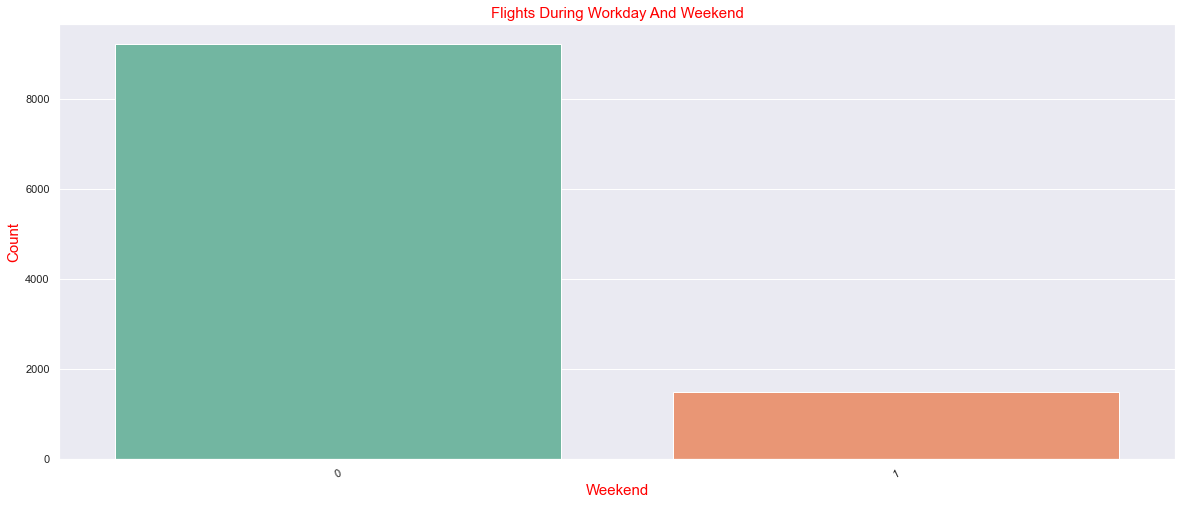

In [14]:
countplot(df, 'Weekend', 'Set2', 'Flights during workday and weekend', (20,8))

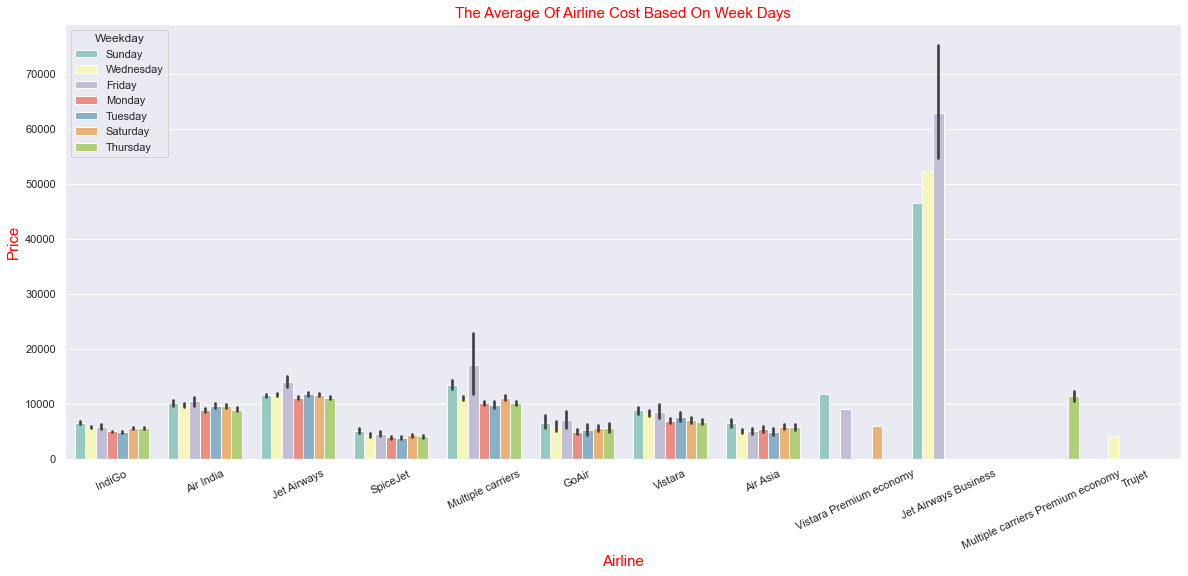

In [15]:
barplot(df, 'Airline', 'Set3', 'The average of airline cost based on week days', (20,8), 'Price', hue = 'Weekday')

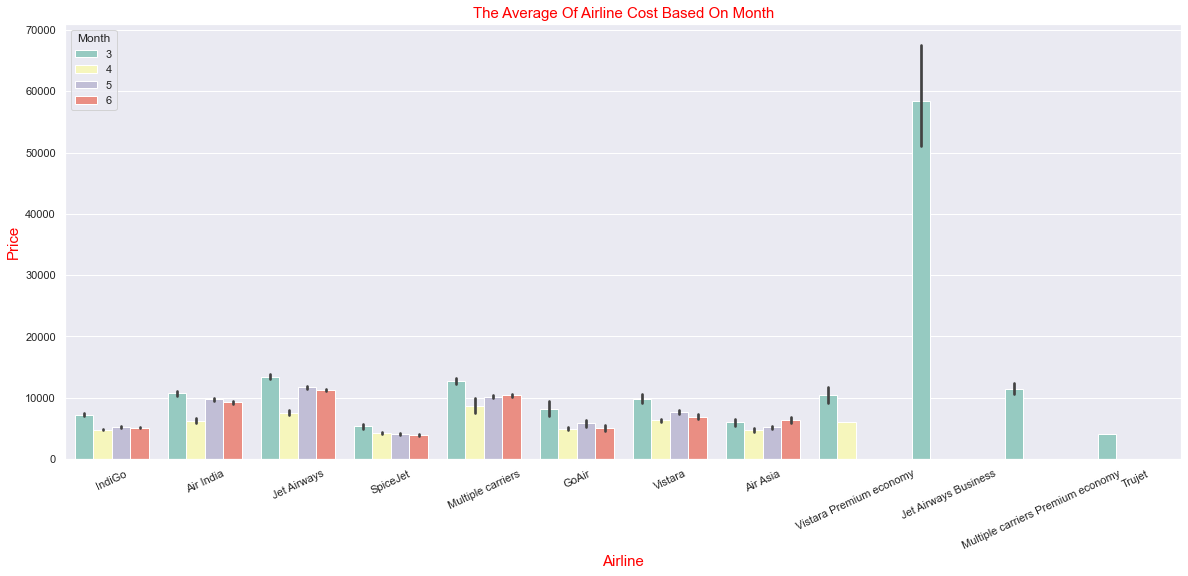

In [16]:
barplot(df, 'Airline', 'Set3', 'The average of airline cost based on month', (20,8), 'Price', hue = 'Month')

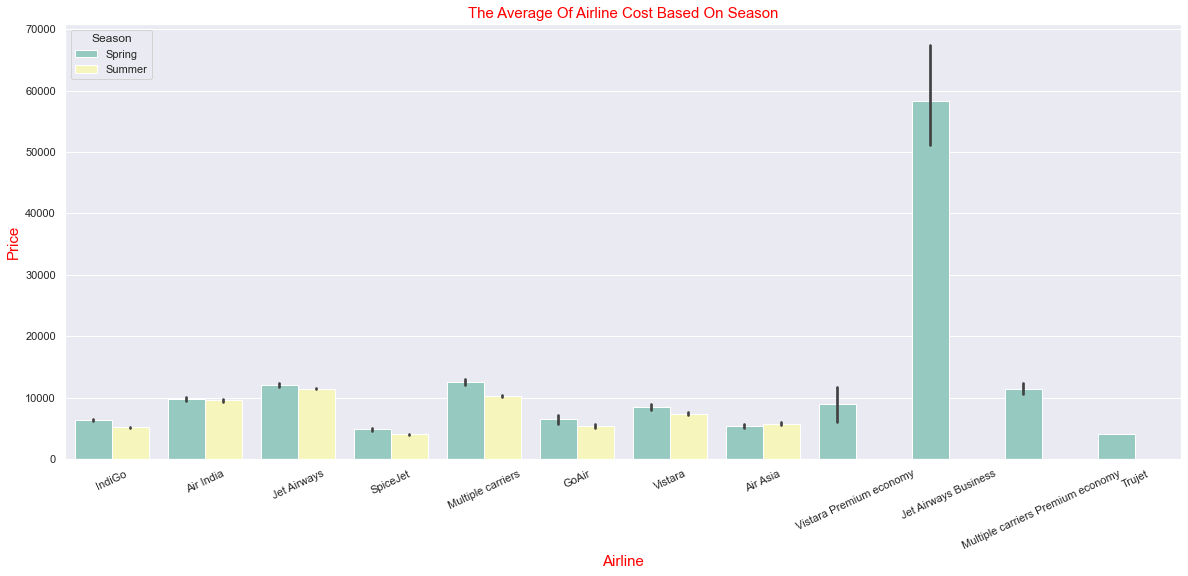

In [17]:
barplot(df, 'Airline', 'Set3', 'The average of airline cost based on season', (20,8), 'Price', hue = 'Season')

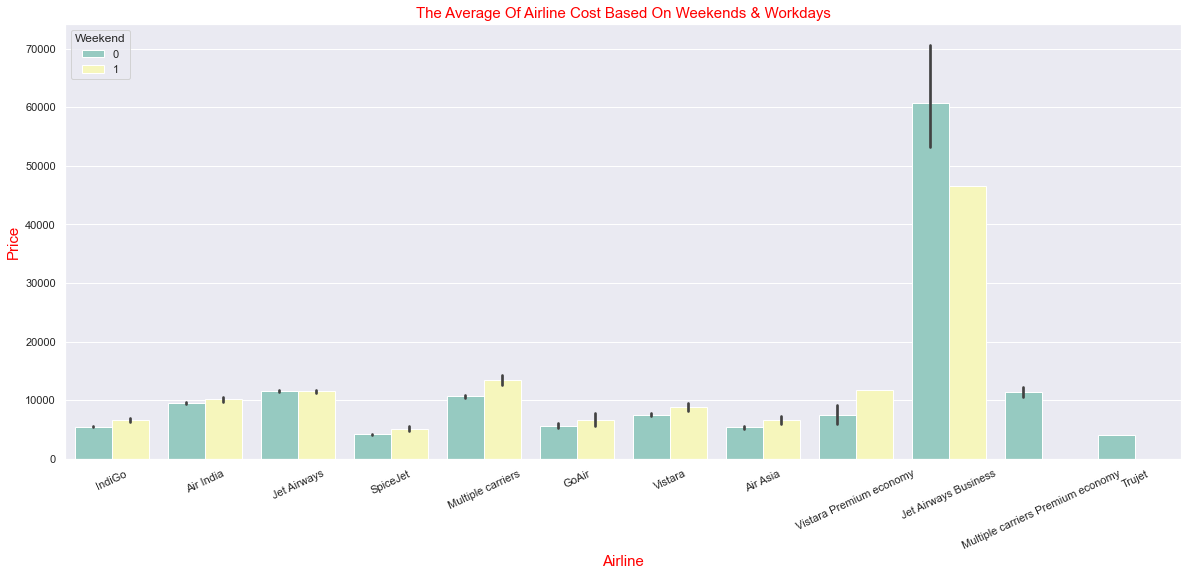

In [18]:
barplot(df, 'Airline', 'Set3', 'The average of airline cost based on Weekends & Workdays', (20,8), 'Price', hue = 'Weekend')

In [19]:
df['Additional_Info'].unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

In [20]:
df['Additional_Info'] = df['Additional_Info'].replace({'No Info': 'No info'})

In [21]:
df['Additional_Info'].unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

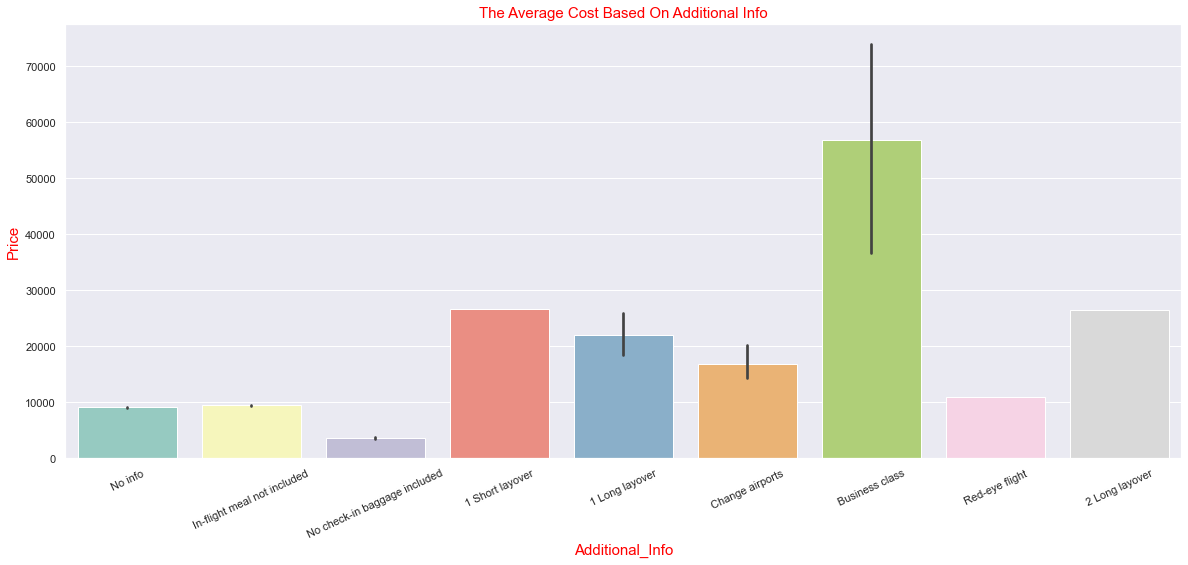

In [22]:
barplot(df, 'Additional_Info', 'Set3', 'The average cost based on additional info', (20,8), 'Price')

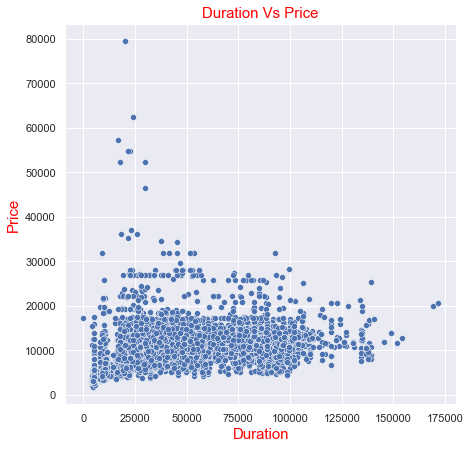

In [23]:
scatterplot(df,'Duration','Price','Duration vs price')

In [24]:
#the correlation of the duration and price
x = df[['Duration', 'Price']].corr()
print('the correlation between price and duration is', round(x['Price'][0], 2), 'Which is a very weak correlation')

the correlation between price and duration is 0.51 Which is a very weak correlation


### Pre-Processing

In [25]:
df_new = df.copy()

In [26]:
df_new

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Month,Weekday,Day,Season,Weekend
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,10200,non-stop,No info,3897,3,Sunday,24,Spring,1
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,26700,2 stops,No info,7662,5,Wednesday,1,Summer,0
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,68400,2 stops,No info,13882,6,Sunday,9,Summer,1
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,19500,1 stop,No info,6218,5,Sunday,12,Summer,1
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,17100,1 stop,No info,13302,3,Friday,1,Spring,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,2019-04-09,Kolkata,Banglore,CCU → BLR,19:55,22:25,9000,non-stop,No info,4107,4,Tuesday,9,Spring,0
10679,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,20:45,23:20,9300,non-stop,No info,4145,4,Saturday,27,Spring,0
10680,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,08:20,11:20,10800,non-stop,No info,7229,4,Saturday,27,Spring,0
10681,Vistara,2019-03-01,Banglore,New Delhi,BLR → DEL,11:30,14:10,9600,non-stop,No info,12648,3,Friday,1,Spring,0


In [27]:
#Detection Of the outlier
Q1 = np.percentile(df_new['Price'], 25, interpolation = 'midpoint')
Q3 = np.percentile(df_new['Price'], 75, interpolation = 'midpoint')
IQR = Q3 - Q1
print(Q1, Q3, IQR)

5277.0 12373.0 7096.0


In [28]:
# Upper bound
upper = np.where(df_new['Price'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df_new['Price'] <= (Q1-1.5*IQR))

In [29]:
#dropping the outliers
df_new.drop(upper[0], inplace = True)
df_new.drop(lower[0], inplace = True)

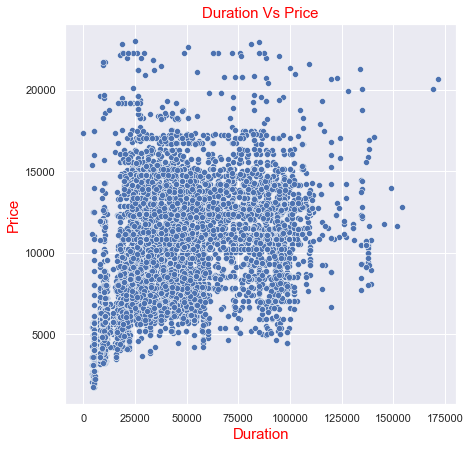

In [30]:
#Prove of no outliers
scatterplot(df_new,'Duration','Price','Duration vs price')

In [31]:
df_new['Total_Stops'].fillna(df_new['Total_Stops'].mode()[0], inplace = True)

In [32]:
x = df_new.drop(['Date_of_Journey', 'Route', 'Dep_Time', 'Arrival_Time', 'Price'], axis = 1)
y = df_new['Price']

In [33]:
x = pd.get_dummies(x, drop_first = True)

In [34]:
#The shape of x
print('X Shape:',x.shape)

X Shape: (10589, 39)


In [35]:
#Scaling the parameters of x
scalar = StandardScaler()
scalar.fit(x)
x_new = scalar.transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size = 0.2, shuffle = False)

In [36]:
#Testing the performance function
def performance(model, x_train, x_test, y_train, y_pred, y_test):
    print('Training_score:', round(model.score(x_train, y_train), 2))
    print('Testing_score:', round(r2_score(y_test, y_pred), 2))
    print('Other metrics in Testing data: ')
    print('MSE' , mean_squared_error(y_test, y_pred))
    print('MAE' , mean_absolute_error(y_test, y_pred))

In [37]:
#fitting model 1 
Lr = LinearRegression()
Lr.fit(x_train, y_train)

#Predicting the data for model 1
Lr_pred = Lr.predict(x_test)

In [38]:
#Test the performance of Linear Regression
performance(Lr, x_train, x_test, y_train, Lr_pred, y_test)

Training_score: 0.72
Testing_score: -6.549247387719315e+16
Other metrics in Testing data: 
MSE 1.0778109927096112e+24
MAE 22558403292.051434


In [39]:
#fitting model 2
DT = DecisionTreeRegressor()
DT.fit(x_train, y_train)

#Predicting the data for model 2
DT_pred = DT.predict(x_test)

In [40]:
#Test the performance of decision tree
performance(DT, x_train, x_test, y_train, DT_pred, y_test)

Training_score: 0.98
Testing_score: 0.8
Other metrics in Testing data: 
MSE 3310377.7223720555
MAE 953.1841247358244


In [41]:
#fitting model 3
RF = RandomForestRegressor()
RF.fit(x_train, y_train)

#Predicting the data for model 3
RF_pred = RF.predict(x_test)

In [42]:
#Test the performance of Random Forest
performance(RF, x_train, x_test, y_train, RF_pred, y_test)

Training_score: 0.97
Testing_score: 0.87
Other metrics in Testing data: 
MSE 2084412.3679753845
MAE 829.6898278080897


### HyberParameter Tuning

Decision Tree

Best Estimator:  DecisionTreeRegressor(max_depth=14, min_samples_leaf=2, min_samples_split=12)
Best Parms:  {'criterion': 'mse', 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 12}
Training_score: 0.92
Testing_score: 0.85
Other metrics in Testing data: 
MSE 2452399.9767602514
MAE 900.9631588137419


Text(0.5, 1.0, 'Predicated Data Vs Actual Data')

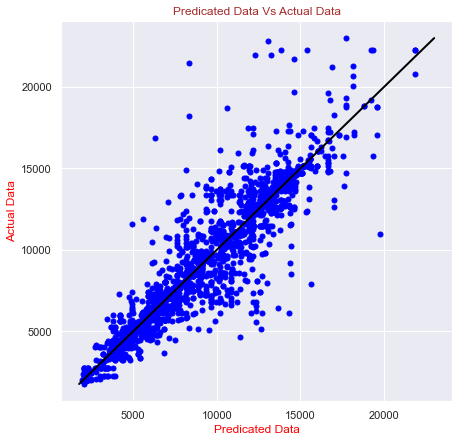

In [47]:
parms = [{'criterion': ['mse'], 'max_depth': list(range(5,20)), 'min_samples_split': list(range(2,15)), 'min_samples_leaf': [2,3,4]}]
grid_search = GridSearchCV(estimator = DecisionTreeRegressor(), param_grid = parms, cv = 10, n_jobs=1)
grid_search = grid_search.fit(x_train,y_train)

#Best Estimator
print('Best Estimator: ', grid_search.best_estimator_)

#Best parms
print('Best Parms: ', grid_search.best_params_)

#predicting the data
grid_pred = grid_search.predict(x_test)

#decision tree performance after tuning
performance(grid_search, x_train, x_test, y_train, grid_pred, y_test)

#plotting the result
plt.scatter(grid_pred, y_test, c='blue', marker = 'o', s = 25)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c = 'black', lw = 2)
plt.xlabel('Predicated Data', c = 'red')
plt.ylabel('Actual Data', c = 'red')
plt.title('Predicated Data Vs Actual Data', c = 'brown')

Random Forest

Training_score: 0.92
Testing_score: 0.88
Other metrics in Testing data: 
MSE 1954671.456760746
MAE 841.7719480542164
Best Estimator:  RandomForestRegressor(max_depth=13, min_samples_leaf=3, min_samples_split=5,
                      n_estimators=500)
Best Parms:  {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 13, 'criterion': 'mse'}


Text(0.5, 1.0, 'Predicated Data Vs Actual Data')

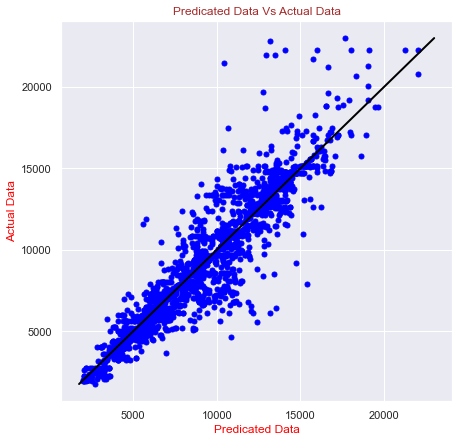

In [48]:
parms = [{'criterion': ['mse'], 'n_estimators': [100,200,300,400,500],'max_depth': list(range(5,15)), 'min_samples_split': list(range(2,15)), 'min_samples_leaf': [2,3,4]}]
rand_search = RandomizedSearchCV(RandomForestRegressor(), parms, cv = 10, n_jobs = 1)

#fitting a model
rand_search.fit(x_train, y_train)

#predicting the data
rand_pred = rand_search.predict(x_test)

#decision tree performance after tuning
performance(rand_search, x_train, x_test, y_train, rand_pred, y_test)

#Best Estimator
print('Best Estimator: ', rand_search.best_estimator_)

#Best parms
print('Best Parms: ', rand_search.best_params_)

#plotting the result
plt.scatter(rand_pred, y_test, c='blue', marker = 'o', s = 25)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c = 'black', lw = 2)
plt.xlabel('Predicated Data', c = 'red')
plt.ylabel('Actual Data', c = 'red')
plt.title('Predicated Data Vs Actual Data', c = 'brown')